# Imports

In [13]:
import networkx as nx
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import torch as th
import os
    
from ddagl import graph_level_nn, graph_feature_extraction, visualization
from ddagl.graph_feature_extraction import bidirected_transformer

# Nasbench Data

In [14]:
if not os.path.exists('datasets/nasbench/nasbench_only108.json'):
    from datasets.nasbench import util as nasbench_util
    if not os.path.exists('datasets/nasbench/nasbench_only108.tfrecord'):
        from urllib import request
        request.urlretrieve('https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord',
                           'datasets/nasbench/nasbench_only108.tfrecord')
    nasbench_util.convert_nasbench('datasets/nasbench/nasbench_only108.tfrecord', 
                                   'datasets/nasbench/nasbench_only108.json')
    

with open('datasets/nasbench/nasbench_only108.json', 'r') as fp:
    X = json.load(fp)
    y_df = pd.DataFrame(X['target']).groupby('graph_id').mean()
    X = X['graphs']
        
y = y_df['test_accuracy'].values
X = [X[graph_id] for graph_id in y_df.index]
X = np.array(list(map(nx.node_link_graph, X)), dtype=object)
del y_df

# Node-level Features


In [ ]:
visualization.draw_workflow_graph(X[3], label_col='type')

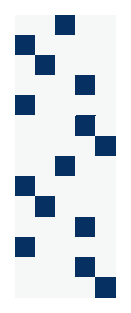

In [15]:
node_level_feature_extractor = graph_feature_extraction.NodeLevelFeatureTransformer(use_configs=False)


a = node_level_feature_extractor.fit_transform(bidirected_transformer.fit_transform(X[:25]))[3][1]
plt.figure(figsize=(2.5, 2.5), dpi=150)
sns.heatmap(a, cmap='RdBu', center=0, square=True, cbar=False);
plt.axis('off');

# Evaluation

In [16]:
cv = ShuffleSplit(n_splits = 5, train_size = 1000, random_state = 42, test_size = 50000)
cv_10k = ShuffleSplit(n_splits = 5, train_size = 10000, random_state = 42, test_size = 50000)
cv_100k = ShuffleSplit(n_splits = 5, train_size = 100000, random_state = 42, test_size = 50000)

def k_tau(y_true, y_pred):
    return kendalltau(y_true, y_pred)[0]

def pearson_corr(y_true, y_pred): 
    return pearsonr(y_true, y_pred)[0]

def spearman_corr(y_true, y_pred): 
    return spearmanr(y_true, y_pred)[0]


score_funs = (k_tau, mean_squared_error, pearson_corr, spearman_corr, r2_score)

def plot_preds(y_true, y_pred):
    ax1, ax2 = plt.subplots(1,2, figsize=(10, 4.5), dpi=200)[1]

    ax1.hexbin(y_true, y_pred, cmap='viridis', mincnt=1, gridsize=200, alpha=.75)
    min_y, max_y = min(np.min(y_pred), np.min(y_true)), max(np.max(y_pred), np.max(y_true))
    ax1.plot([min_y, max_y], [min_y, max_y], 'k--')
    ax1.set_xlabel('true accuracy'), ax1.set_ylabel('predicted accuracy')
    ax1.set_title(r'$\rho_p = {}$'.format(round(pearson_corr(y_true, y_pred), 3)))
    ax1.grid()

    y_true_ranks, y_pred_ranks = np.argsort(np.argsort(y_true)), np.argsort(np.argsort(y_pred))
    ax2.scatter(y_true_ranks, y_pred_ranks, s=.5, alpha = .75)
    ax2.set_xlabel('true rank'), ax2.set_ylabel('predicted rank')
    ax2.set_title(r'$\rho_s = {}$'.format(round(pearson_corr(y_true_ranks, y_pred_ranks), 3)))
    plt.tight_layout()
    plt.show()


def cv_score(est, X, y, cv = cv, show_training_history: bool = False, plot_preds: bool = False,
            set_est_random_state:bool = True, print_results:bool = True):    
    score_dicts = []
    for random_state, (train_ind, test_ind) in enumerate(cv.split(X, y)):
        X_train, y_train = X[train_ind], y[train_ind]
        X_test, y_test = X[test_ind], y[test_ind]
        if set_est_random_state:
            if type(est) is Pipeline:
                for _, step in est.steps:
                    if hasattr(step, 'random_state'):
                        step.random_state = random_state
            elif hasattr(est, 'random_state'):
                est.random_state = random_state
            
        est.fit(X_train, y_train)
        
        if show_training_history and type(est) is Pipeline and hasattr(est.steps[-1][-1], 'show_training_history'):
            est.steps[-1][-1].show_training_history(figsize=(8, 5), epoch_cutoff=.5)
            plt.show()
        
        y_pred = est.predict(X_test)
        score_dicts.append({score_fun.__name__ : score_fun(y_test, y_pred) for score_fun in score_funs})
        if plot_preds:
            plot_preds(y_test, y_pred)
    
    scores_df = pd.DataFrame(score_dicts)
    if print_results:
        print(scores_df.aggregate((np.mean, np.std)))
    return scores_df

# Baseline

## Dummy Regressor

In [17]:
from sklearn.dummy import DummyRegressor

baseline_reg = DummyRegressor()
cv_score(baseline_reg, X=X, y=y)

      k_tau  mean_squared_error  pearson_corr  spearman_corr  r2_score
mean    NaN            0.003393           NaN            NaN -0.000209
std     NaN            0.000194           NaN            NaN  0.000301


,k_tau,mean_squared_error,pearson_corr,spearman_corr,r2_score
0,NaN,0.003083,NaN,NaN,-0.000015
1,NaN,0.003335,NaN,NaN,-0.000001
2,NaN,0.003573,NaN,NaN,-0.000350
3,NaN,0.003472,NaN,NaN,-0.000678
4,NaN,0.003500,NaN,NaN,-0.000002


# P-GCN

In [18]:
graph_reg_default_kwargs = dict(scoring=k_tau, nb_epochs = 150, random_state=42, batch_size = 100, 
                                dense_layer_sizes = (64, ))

## 1k Training Instances

In [25]:
graph_reg = graph_level_nn.GraphLevelRegressor(**graph_reg_default_kwargs)
graph_reg_pipeline = make_pipeline(bidirected_transformer, node_level_feature_extractor, graph_reg)
cv_score(graph_reg_pipeline, X=X, y=y)

         k_tau  mean_squared_error  pearson_corr  spearman_corr  r2_score
mean  0.829052            0.003788      0.588977       0.961363 -0.117888
std   0.006700            0.000162      0.024523       0.002983  0.035800


,k_tau,mean_squared_error,pearson_corr,spearman_corr,r2_score
0,0.826740,0.003559,0.610462,0.960755,-0.154417
1,0.832354,0.003731,0.567626,0.962862,-0.118860
2,0.834985,0.003793,0.570681,0.963781,-0.061914
3,0.832805,0.003857,0.620289,0.963000,-0.111512
4,0.818374,0.004000,0.575825,0.956418,-0.142738


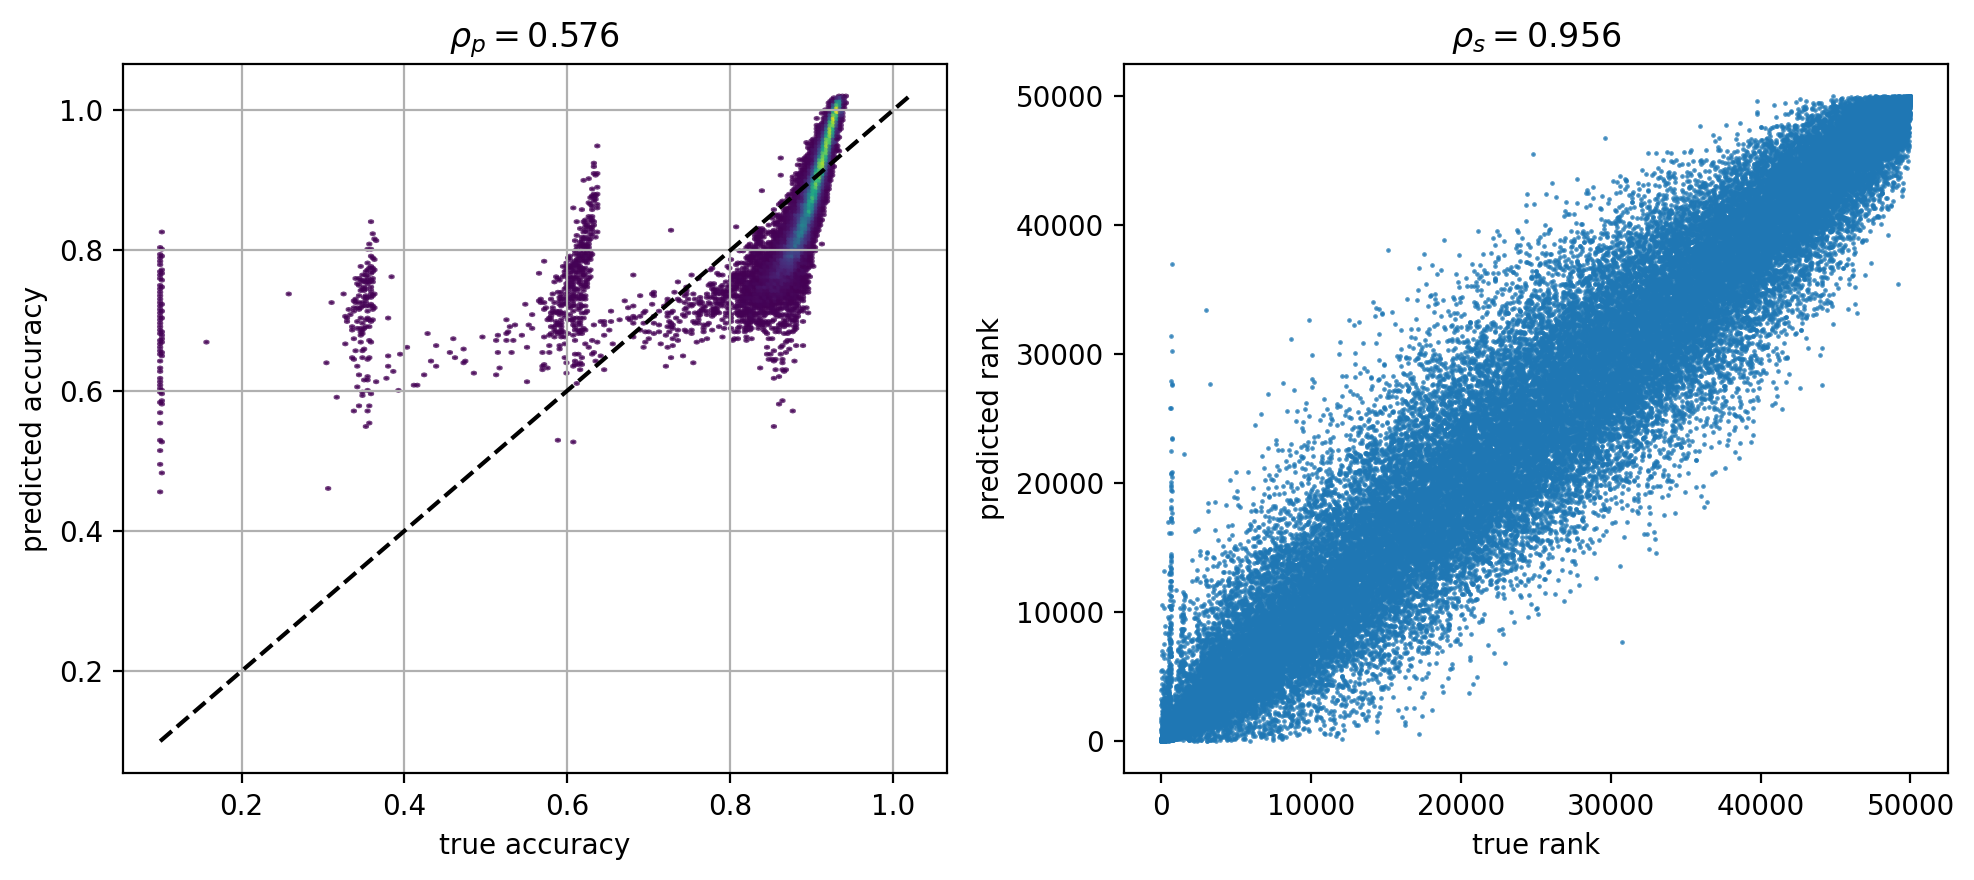

In [24]:
train_ids, test_ids = list(cv.split(X, y))[-1]
graph_reg_pipeline.fit(X[train_ids], y[train_ids])
plot_preds(y[test_ids], graph_reg_pipeline.predict(X[test_ids]))

In [17]:
graph_reg.model_

ResGCN(
  (conv_layers_): ModuleList(
    (0): TAGConv(
      (lin): Linear(in_features=15, out_features=128, bias=False)
    )
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): TAGConv(
      (lin): Linear(in_features=384, out_features=128, bias=False)
    )
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): TAGConv(
      (lin): Linear(in_features=384, out_features=128, bias=False)
    )
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): TAGConv(
      (lin): Linear(in_features=384, out_features=128, bias=False)
    )
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): TAGConv(
      (lin): Linear(in_features=384, out_features=128, bias=False)
    )
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

##  381 Training Instances

In [26]:
graph_reg = graph_level_nn.GraphLevelRegressor(**graph_reg_default_kwargs)
graph_reg.batch_size = 50
graph_reg_pipeline = make_pipeline(bidirected_transformer, node_level_feature_extractor, graph_reg)

cv_score(graph_reg_pipeline, X=X, y=y,
         cv=ShuffleSplit(n_splits = 5, train_size = 381, random_state = 42, test_size = 50000))

         k_tau  mean_squared_error  pearson_corr  spearman_corr  r2_score
mean  0.798475            0.004002      0.534216       0.946838 -0.181192
std   0.007972            0.000153      0.023891       0.004046  0.039083


,k_tau,mean_squared_error,pearson_corr,spearman_corr,r2_score
0,0.800086,0.003763,0.553349,0.947284,-0.220796
1,0.788616,0.003993,0.550378,0.942091,-0.197239
2,0.799814,0.003988,0.535485,0.946943,-0.116384
3,0.809952,0.004098,0.538137,0.953054,-0.181198
4,0.793906,0.004167,0.493734,0.944816,-0.190344


## 1906 Training Instances

In [27]:
graph_reg = graph_level_nn.GraphLevelRegressor(**graph_reg_default_kwargs)
graph_reg.batch_size = 200
graph_reg_pipeline = make_pipeline(bidirected_transformer, node_level_feature_extractor, graph_reg)

cv_score(graph_reg_pipeline, X=X, y=y,
         cv=ShuffleSplit(n_splits = 5, train_size = 1906, random_state = 42, test_size = 50000))

         k_tau  mean_squared_error  pearson_corr  spearman_corr  r2_score
mean  0.848451            0.003616      0.605577       0.969410 -0.067161
std   0.001320            0.000174      0.033213       0.000405  0.039061


,k_tau,mean_squared_error,pearson_corr,spearman_corr,r2_score
0,0.847076,0.003415,0.641410,0.968952,-0.107909
1,0.849037,0.003629,0.581723,0.969620,-0.088215
2,0.850315,0.003879,0.572644,0.969987,-0.085781
3,0.847331,0.003513,0.641106,0.969163,-0.012479
4,0.848496,0.003645,0.591004,0.969327,-0.041422


# Loss Configurations

## MSE & Hinge Ranking Weights

In [30]:
loss_response_dfs = []
for w_1 in [0, .05, 0.1, 0.25, 0.5, 0.75, .9, .95, 1]:
    w_2 = 1-w_1
    graph_reg = graph_level_nn.GraphLevelRegressor(**graph_reg_default_kwargs)
    graph_reg.loss_criterion = graph_level_nn.combine_loss_criteria([th.nn.MSELoss(), 
                                                                           graph_level_nn.hinge_ranking_loss], 
                                                                          [w_1, w_2])
    graph_reg_pipeline = make_pipeline(bidirected_transformer, node_level_feature_extractor, graph_reg)

    scores_df = cv_score(graph_reg_pipeline, X=X, y=y, print_results=False)
    scores_df['w_1'], scores_df['w_2'] = w_1, w_2
    loss_response_dfs.append(scores_df)
hr_loss_response_df = pd.concat(loss_response_dfs)

In [31]:
hr_loss_response_df.groupby('w_1').aggregate(['mean', 'std'])

k_tau           mean_squared_error           pearson_corr            \
          mean       std               mean       std         mean       std   
w_1                                                                            
0.00  0.830256  0.003371           0.865506  0.104691     0.491670  0.007675   
0.05  0.833314  0.006733           0.015527  0.001162     0.531382  0.009254   
0.10  0.835256  0.002454           0.011006  0.000345     0.536457  0.007246   
0.25  0.835754  0.004263           0.006413  0.000203     0.543119  0.006265   
0.50  0.829052  0.006700           0.003788  0.000162     0.588977  0.024523   
0.75  0.817041  0.003701           0.002539  0.000137     0.624262  0.013801   
0.90  0.788311  0.007309           0.002129  0.000122     0.635335  0.006742   
0.95  0.761854  0.013893           0.001997  0.000097     0.645747  0.005619   
1.00  0.653360  0.033426           0.002061  0.000090     0.629339  0.013103   

     spearman_corr              r2_score              w_2       
              mean       std        mean        std  mean  std  
w_1                                                             
0.00      0.961836  0.001462 -254.452147  29.268571  1.00  0.0  
0.05      0.962991  0.003046   -3.597460   0.528271  0.95  0.0  
0.10      0.963920  0.000993   -2.255070   0.249199  0.90  0.0  
0.25      0.964111  0.001892   -0.895103   0.114151  0.75  0.0  
0.50      0.961363  0.002983   -0.117888   0.035800  0.50  0.0  
0.75      0.955970  0.001616    0.250650   0.038515  0.25  0.0  
0.90      0.941045  0.003350    0.372041   0.019043  0.10  0.0  
0.95      0.926001  0.008754    0.410889   0.009719  0.05  0.0  
1.00      0.842092  0.028792    0.391941   0.013988  0.00  0.0

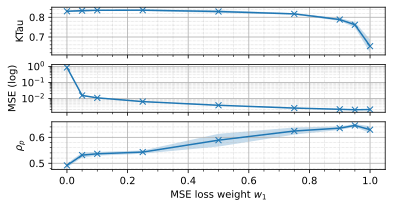

In [41]:
def plot_with_ci(index, means, std, ax, label=''):
    ax.plot(index, means, '-x', label=label, linewidth=1.5)
    ax.fill_between(index, means-std, means+std, alpha = .25)      
    ax.minorticks_on(), ax.grid(which='minor', linestyle=':', linewidth=.5), ax.grid()

ax1, ax2, ax3 = plt.subplots(3, figsize=(6,3), dpi=150, sharex=True)[1]

df_mean = hr_loss_response_df.groupby('w_1').aggregate('mean')
df_std = hr_loss_response_df.groupby('w_1').std()

plot_with_ci(df_mean.index, df_mean.k_tau, df_std.k_tau, ax=ax1)
plot_with_ci(df_mean.index, df_mean.mean_squared_error, df_std.mean_squared_error, ax=ax2)
plot_with_ci(df_mean.index, df_mean.pearson_corr, df_std.pearson_corr, ax=ax3)
ax2.semilogy()
ax1.set_ylabel('KTau'), ax3.set_ylabel(r'$\rho_p$'), ax2.set_ylabel('MSE (log)');
ax3.set_xlabel(r'MSE loss weight $w_1$');

## Hinge Ranking margin

In [ ]:
margin_response_dfs = []
for margin in (0.1, 0.05, 0.2, 0.02):
    hr_loss = lambda y, y_: graph_level_nn.hinge_ranking_loss(y, y_, margin=margin)

    graph_reg = graph_level_nn.GraphLevelRegressor(**graph_reg_default_kwargs)
    graph_reg.loss_criterion = graph_level_nn.combine_loss_criteria([th.nn.MSELoss(), hr_loss], [.5, .5])
    graph_reg_pipeline = make_pipeline(bidirected_transformer, node_level_feature_extractor, graph_reg)

    scores_df = cv_score(graph_reg_pipeline, X=X, y=y, print_results=False)
    scores_df['margin'] = margin
    margin_response_dfs.append(scores_df)
margin_response_df = pd.concat(margin_response_dfs)


In [36]:
margin_response_df.groupby('margin').aggregate(['mean', 'std'])

k_tau           mean_squared_error           pearson_corr  \
            mean       std               mean       std         mean   
margin                                                                 
0.02    0.825371  0.010255           0.002168  0.000213     0.626907   
0.05    0.829052  0.006700           0.003788  0.000162     0.588977   
0.10    0.831765  0.005247           0.008246  0.000443     0.556723   
0.20    0.833448  0.003267           0.020530  0.000873     0.537847   

                 spearman_corr            r2_score            
             std          mean       std      mean       std  
margin                                                        
0.02    0.032236      0.959570  0.004815  0.361795  0.035355  
0.05    0.024523      0.961363  0.002983 -0.117888  0.035800  
0.10    0.016497      0.962498  0.002300 -1.435231  0.149391  
0.20    0.008787      0.963126  0.001555 -5.071779  0.493168